# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

> This data represents the results collected from 17 different campaigns performed between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import time

# Visualization tools
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Scikit learn tools
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error, PredictionErrorDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor 


In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
# Check NaN, 0 values and number of unique values, all at once

def print_missing_info(df_to_check, other_value = 0, sort_by = 'Missing #', ascending = False):
    nan_df = pd.DataFrame(df_to_check.isnull().sum(),columns=['Missing #'])
    nan_df['Missing %'] = round(df_to_check.isnull().mean()*100,2)
    nan_df[f'{other_value} #'] = df_to_check.eq(other_value).sum()
    nan_df[f'{other_value} %'] = round(df_to_check.eq(other_value).mean()*100,2)
    nan_df['Unique'] = df_to_check.apply(lambda col: len(col.unique()))
    nan_df['Type'] = df_to_check.apply(lambda col: col.dtype)
    print(f"Sorted by '{sort_by}' / Ascending = {ascending}\n")
    print(nan_df.sort_values(by=sort_by,ascending=False))
    
print_missing_info(df)

Sorted by 'Missing #' / Ascending = False

                Missing #  Missing %    0 #    0 %  Unique     Type
age                     0        0.0      0   0.00      78    int64
campaign                0        0.0      0   0.00      42    int64
nr.employed             0        0.0      0   0.00      11  float64
euribor3m               0        0.0      0   0.00     316  float64
cons.conf.idx           0        0.0      0   0.00      26  float64
cons.price.idx          0        0.0      0   0.00      26  float64
emp.var.rate            0        0.0      0   0.00      10  float64
poutcome                0        0.0      0   0.00       3   object
previous                0        0.0  35563  86.34       8    int64
pdays                   0        0.0     15   0.04      27    int64
duration                0        0.0      4   0.01    1544    int64
job                     0        0.0      0   0.00      12   object
day_of_week             0        0.0      0   0.00       5   object
month

In [6]:
### Showing all categorical values at once for exploration ###

for col in df:
    if df[col].dtype == "object":
        print(f'\033[1m{col}\033[0m (count: {len(df[col].unique())}) =>\t{df[col].unique()}')

job (count: 12) =>	['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital (count: 4) =>	['married' 'single' 'divorced' 'unknown']
education (count: 8) =>	['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default (count: 3) =>	['no' 'unknown' 'yes']
housing (count: 3) =>	['no' 'yes' 'unknown']
loan (count: 3) =>	['no' 'yes' 'unknown']
contact (count: 2) =>	['telephone' 'cellular']
month (count: 10) =>	['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week (count: 5) =>	['mon' 'tue' 'wed' 'thu' 'fri']
poutcome (count: 3) =>	['nonexistent' 'failure' 'success']
y (count: 2) =>	['no' 'yes']


In [7]:
# Check and remove duplicates
if df.duplicated().sum() > 0:
    print(f"Removing {df.duplicated().sum()} duplicated rows")
    df.drop_duplicates(inplace=True)
    
df.shape

Removing 12 duplicated rows


(41176, 21)

> - There is no missing value in the dataset and only 12 duplicated rows.
> - The categorical features will require to be transformed/encoded before being used. Several features have an 'unknown' value: we can decide to keep it as a separate class or delete/impute.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

> __Business understanding__<br>
> The business objective is to increase the efficiency of the direct marketing campaigns aiming at getting a customer to subscribe a deposit. Better efficacy can be obtain by reducing the number of calls (number of calls, duraction of calls, number of targeted prospects) while keeping or improving the success rate of a deposit.
> The underlying data mining problem is to build a classification model that can accurately predict whether a conversion (ie. a deposit) will occur for a given client. Interpretability of the model will be important in order to gain knowledge on the most important factors that lead a prospect to make a deposit. 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [9]:
df_basic = df.loc[:,'job':'contact']
df_basic['y'] = df['y']
df_basic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job        41176 non-null  object
 1   marital    41176 non-null  object
 2   education  41176 non-null  object
 3   default    41176 non-null  object
 4   housing    41176 non-null  object
 5   loan       41176 non-null  object
 6   contact    41176 non-null  object
 7   y          41176 non-null  object
dtypes: object(8)
memory usage: 2.8+ MB


In [10]:
### Showing all categorical values at once for exploration ###

for col in df_basic:
    if df_basic[col].dtype == "object":
        print(f'\033[1m{col}\033[0m (count: {len(df_basic[col].unique())}) =>\t{df_basic[col].unique()}')

job (count: 12) =>	['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital (count: 4) =>	['married' 'single' 'divorced' 'unknown']
education (count: 8) =>	['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default (count: 3) =>	['no' 'unknown' 'yes']
housing (count: 3) =>	['no' 'yes' 'unknown']
loan (count: 3) =>	['no' 'yes' 'unknown']
contact (count: 2) =>	['telephone' 'cellular']
y (count: 2) =>	['no' 'yes']


In [11]:
# Show the features with 'unknown' value
print_missing_info(df_basic, other_value = 'unknown', sort_by = 'unknown %')

Sorted by 'unknown %' / Ascending = False

           Missing #  Missing %  unknown #  unknown %  Unique    Type
default            0        0.0       8596      20.88       3  object
education          0        0.0       1730       4.20       8  object
housing            0        0.0        990       2.40       3  object
loan               0        0.0        990       2.40       3  object
job                0        0.0        330       0.80      12  object
marital            0        0.0         80       0.19       4  object
contact            0        0.0          0       0.00       2  object
y                  0        0.0          0       0.00       2  object


default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64


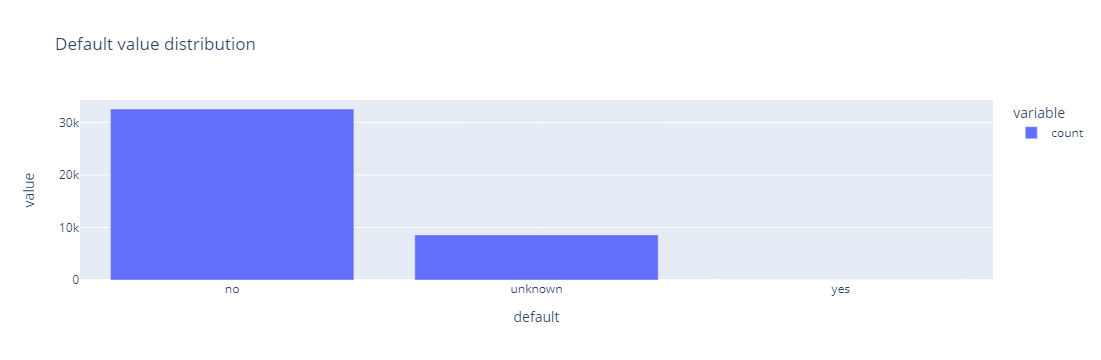

education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64


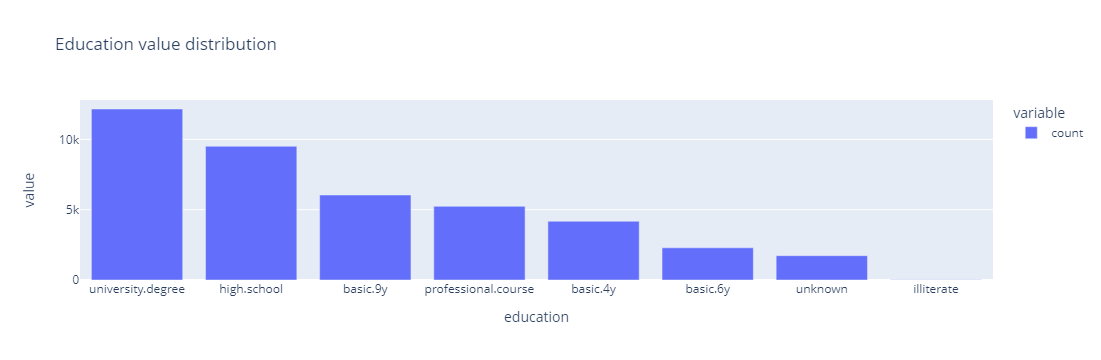

In [12]:
# Distribution of unknown

# Distribution of whether a prospect has defaulted or not
print(df_basic.default.value_counts())
fig = px.bar(df_basic.default.value_counts(), title="Default value distribution")
fig.show()

# Distribution of education types
print(df_basic.education.value_counts())
fig = px.bar(df_basic.education.value_counts(), title="Education value distribution")
fig.show()


marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64


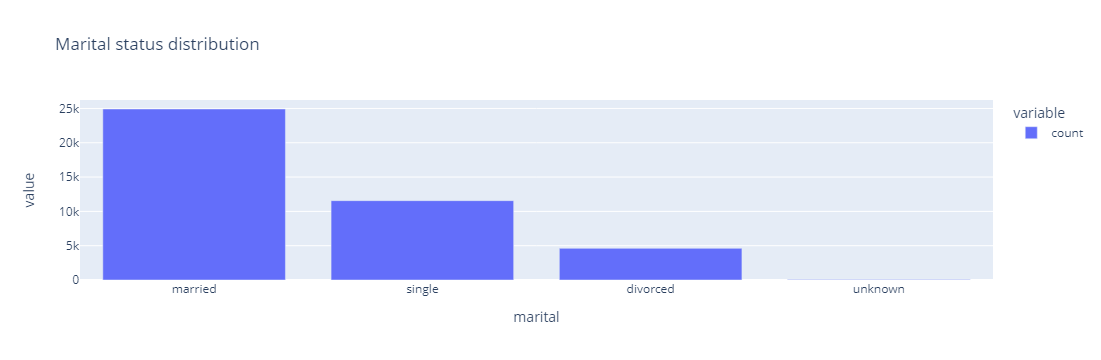

job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64


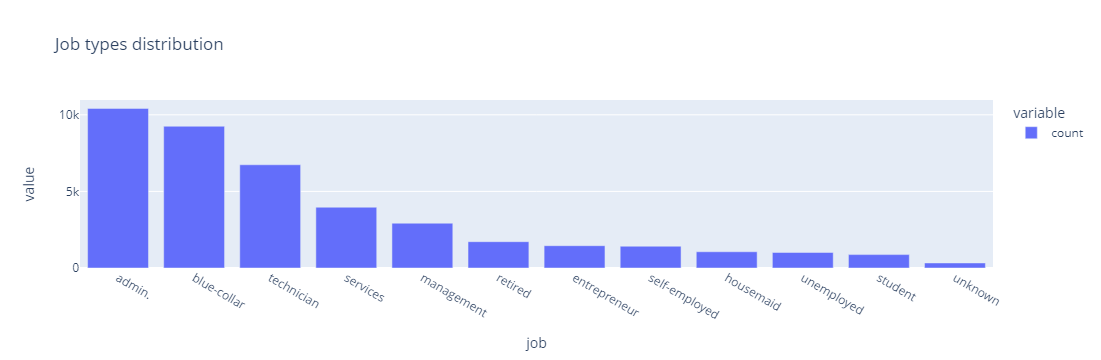

In [13]:
# Distribution of marital statuses
print(df_basic.marital.value_counts())
fig = px.bar(df_basic.marital.value_counts(), title="Marital status distribution")
fig.show()

print(df_basic.job.value_counts())
fig = px.bar(df_basic.job.value_counts(), title="Job types distribution")
fig.show()

housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64


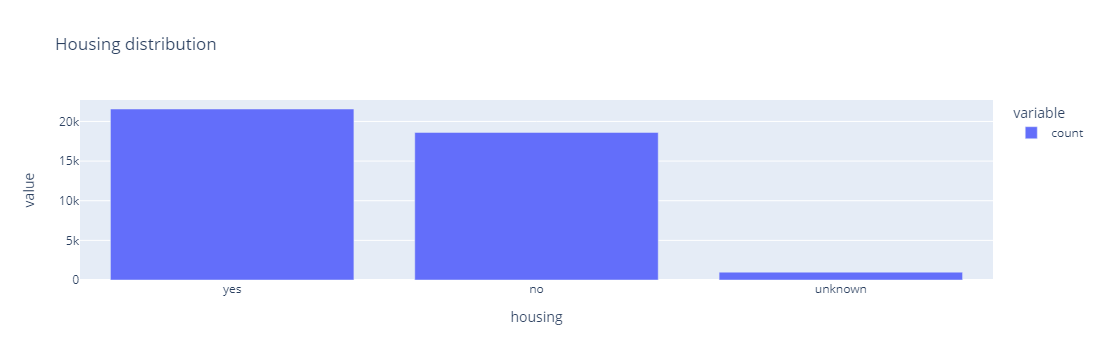

loan
no         33938
yes         6248
unknown      990
Name: count, dtype: int64


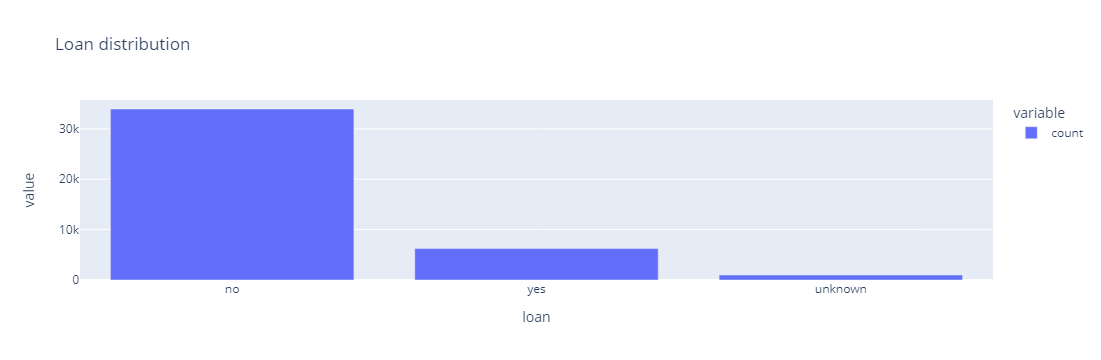

In [14]:
# Distribution of housing types
print(df_basic.housing.value_counts())
fig = px.bar(df_basic.housing.value_counts(), title="Housing distribution")
fig.show()

# Distribution of loan types
print(df_basic.loan.value_counts())
fig = px.bar(df_basic.loan.value_counts(), title="Loan distribution")
fig.show()

> Considering the various distributions, I have elected to:
> - Drop the rows with unknown for housing, loan, marital and job
> - Drop the default columns (totally skewed towards 'no default')
> - Replace unknown by "university degree" for Education  

In [15]:
# housing, loan, marital, job => drop rows with unknown
# drop the default column (totally skewed towards 'no default')
# Education => impute university degree for unknown

print(df_basic.shape)
df_basic.drop(columns = ['default'], inplace=True)
df_basic = df_basic[ (df_basic['housing'] != 'unknown') & (df_basic['loan'] != 'unknown') & (df_basic['marital'] != 'unknown') & (df_basic['job'] != 'unknown')]
df_basic.education.replace({"unknown":"university.degree"}, inplace=True)
print(df_basic.shape)                   

(41176, 8)
(39791, 7)


In [16]:
print_missing_info(df_basic, other_value = 'unknown', sort_by = 'unknown %')

Sorted by 'unknown %' / Ascending = False

           Missing #  Missing %  unknown #  unknown %  Unique    Type
job                0        0.0          0        0.0      11  object
marital            0        0.0          0        0.0       3  object
education          0        0.0          0        0.0       7  object
housing            0        0.0          0        0.0       2  object
loan               0        0.0          0        0.0       2  object
contact            0        0.0          0        0.0       2  object
y                  0        0.0          0        0.0       2  object


In [17]:
# Now that the basic dataframe is cleaned, let's OH encode
df_clean = pd.get_dummies(df_basic, columns=['job', 'marital',  'education', 'housing', 'loan', 'contact'], drop_first = True)

In [18]:
# Fit and transform the 'y' column to numerical values
df_clean['y'] = LabelEncoder().fit_transform(df_clean['y'])

In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39791 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   y                              39791 non-null  int32
 1   job_blue-collar                39791 non-null  bool 
 2   job_entrepreneur               39791 non-null  bool 
 3   job_housemaid                  39791 non-null  bool 
 4   job_management                 39791 non-null  bool 
 5   job_retired                    39791 non-null  bool 
 6   job_self-employed              39791 non-null  bool 
 7   job_services                   39791 non-null  bool 
 8   job_student                    39791 non-null  bool 
 9   job_technician                 39791 non-null  bool 
 10  job_unemployed                 39791 non-null  bool 
 11  marital_married                39791 non-null  bool 
 12  marital_single                 39791 non-null  bool 
 13  education_basic.6y   

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [20]:
# Let's split with a stratified y
X_train, X_test, y_train, y_test = train_test_split(df_clean.drop('y', axis = 1), df_clean['y'], test_size=0.25, random_state=42, stratify=df_clean['y'])

y
0    26479
1     3364
Name: count, dtype: int64


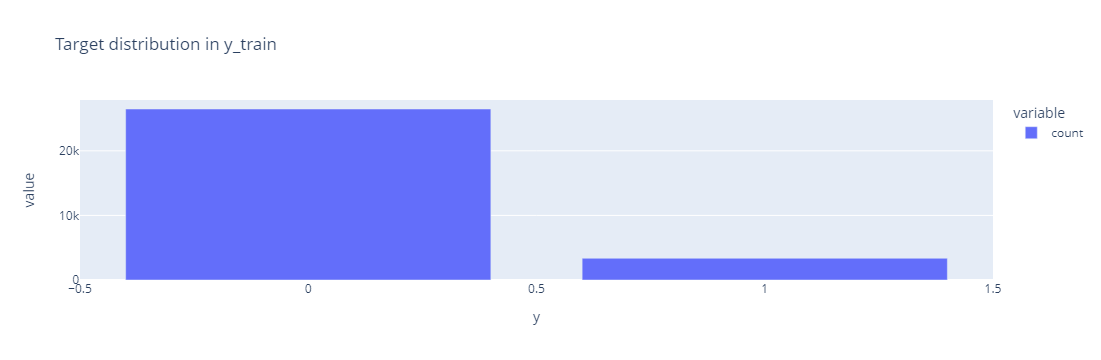

y
0    8826
1    1122
Name: count, dtype: int64


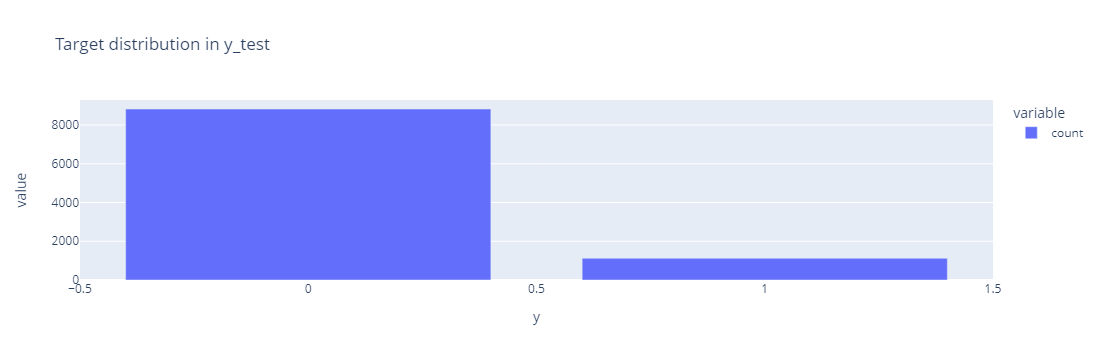

In [21]:
print(y_train.value_counts())
fig = px.bar(y_train.value_counts(), title="Target distribution in y_train")
fig.show()

print(y_test.value_counts())
fig = px.bar(y_test.value_counts(), title="Target distribution in y_test")
fig.show()




> The train and test sets are stratified but still very imbalanced. We will keep it that way for the baseline model.

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [22]:
dummy_clf = DummyClassifier().fit(X_train,y_train)
baseline_score = dummy_clf.score(X_test,y_test)
print(baseline_score)

0.8872135102533173


> __Interpretation__<br>
> The performance of the baseline model is very high which tells us it is due to the imbalanced nature of the dataset. We will have to be careful with the interpretation of the various performance metrics of our models and/or find a way to better balance the dataset. 

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [23]:
#lr = LogisticRegression(class_weight = 'balanced').fit(X_train,y_train)
start = time.time()
lr = LogisticRegression().fit(X_train,y_train)
lr_train_time = time.time() - start

lr_acc_train = lr.score(X_train,y_train)
lr_acc_test = lr.score(X_test,y_test)

print(lr_acc_train)
print(lr_acc_test)
print(lr_train_time)

0.8873102570116945
0.887112987535183
0.07199716567993164


### Problem 9: Score the Model

What is the accuracy of your model?

In [24]:
# Function that returns the scores for a certain probability threshold
# Takes a target array, a prediction array for 0 and 1 and a threshold
# Returns the accuracy, precision, recall and ROC scores for that threshold 

def get_scores_by_threshold(y_test, preds, thresh = .5):
    new_preds = np.where(preds[:, 1] > thresh, 1,0)
    fpr, tpr, thr = roc_curve(y_test, new_preds)
    return (round(accuracy_score(y_test, new_preds),6),
            round(precision_score(y_test,new_preds,zero_division=0),6), 
            round(recall_score(y_test,new_preds,zero_division=0),6), 
            round(roc_auc_score(y_test,new_preds),6), 
            fpr, tpr)



Accuracy with Low threshold for conversion: 0.746984
Precision with Low threshold for conversion: 0.201796
Recall with Low threshold for conversion: 0.420677
ROC AUC with Low threshold for conversion: 0.604572



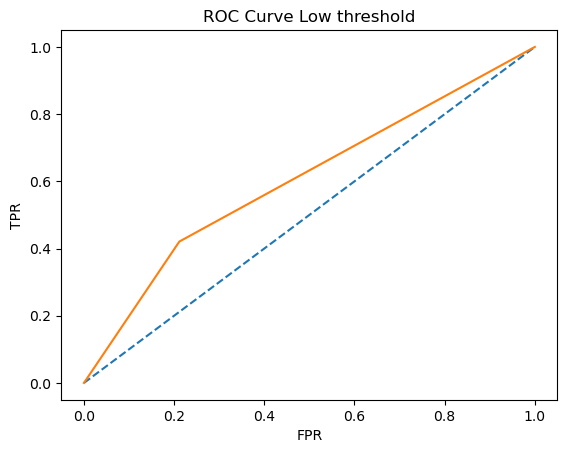

Accuracy with Mid threshold for conversion: 0.887113
Precision with Mid threshold for conversion: 0.0
Recall with Mid threshold for conversion: 0.0
ROC AUC with Mid threshold for conversion: 0.499943



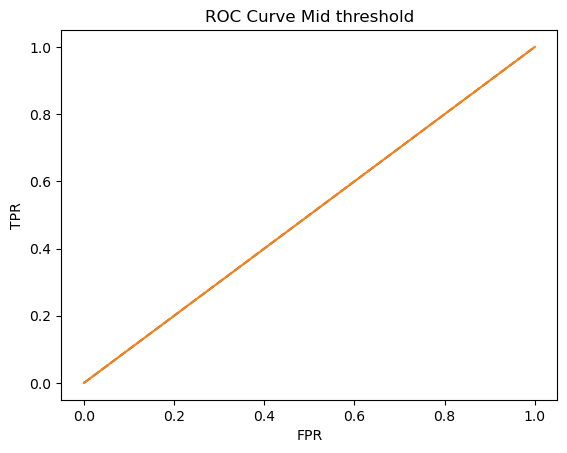

Accuracy with High threshold for conversion: 0.887214
Precision with High threshold for conversion: 0.0
Recall with High threshold for conversion: 0.0
ROC AUC with High threshold for conversion: 0.5



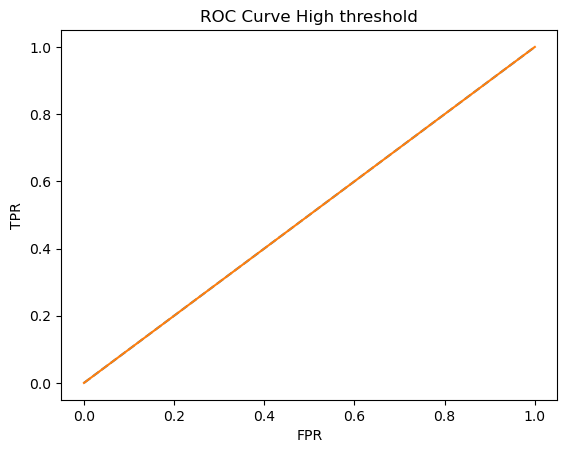

In [25]:
### Low probability threshold

a, p, r, roc, fpr, tpr = get_scores_by_threshold(y_test, lr.predict_proba(X_test), thresh = .15)

print(f'Accuracy with Low threshold for conversion: {a}')
print(f'Precision with Low threshold for conversion: {p}')
print(f'Recall with Low threshold for conversion: {r}')
print(f'ROC AUC with Low threshold for conversion: {roc}\n')

# Visualize the ROC curve
plt.plot([0,1],[0,1],'--')
plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve Low threshold")
plt.show()


### Medium probability threshold

a, p, r, roc, fpr, tpr = get_scores_by_threshold(y_test, lr.predict_proba(X_test), thresh = .50)

# lr_acc_train = lr.score(X_train,y_train)
# lr_acc_test = lr.score(X_test,y_test)
# lr_train_time = stop - start

print(f'Accuracy with Mid threshold for conversion: {a}')
print(f'Precision with Mid threshold for conversion: {p}')
print(f'Recall with Mid threshold for conversion: {r}')
print(f'ROC AUC with Mid threshold for conversion: {roc}\n')

# Visualize the ROC curve
plt.plot([0,1],[0,1],'--')
plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve Mid threshold")
plt.show()


### High probability threshold

a, p, r, roc, fpr, tpr = get_scores_by_threshold(y_test, preds = lr.predict_proba(X_test), thresh = .75)

print(f'Accuracy with High threshold for conversion: {a}')
print(f'Precision with High threshold for conversion: {p}')
print(f'Recall with High threshold for conversion: {r}')
print(f'ROC AUC with High threshold for conversion: {roc}\n')

# Visualize the ROC curve
plt.plot([0,1],[0,1],'--')
plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve High threshold")
plt.show()


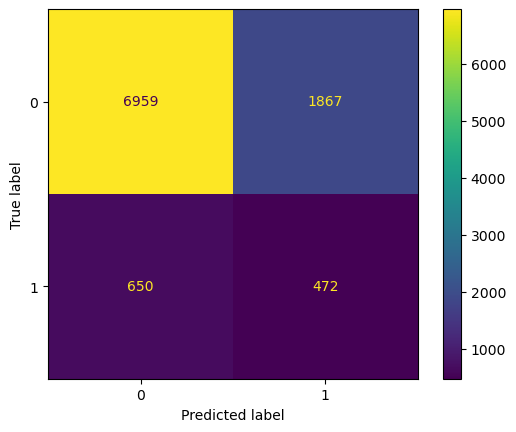

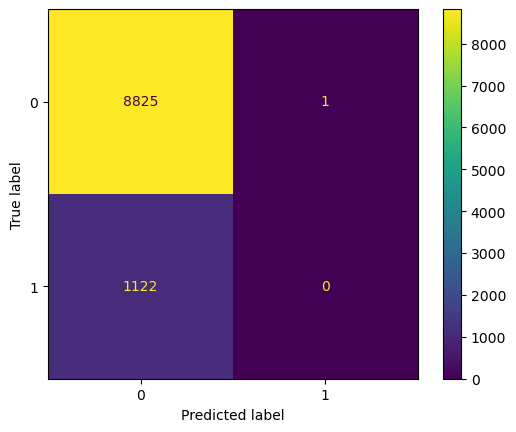

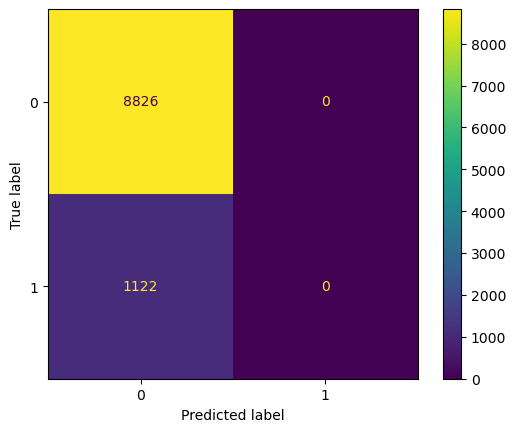

In [26]:
low_preds = np.where(lr.predict_proba(X_test)[:, 1] > 0.15, 1,0)
mid_preds = np.where(lr.predict_proba(X_test)[:, 1] > 0.5, 1,0)
high_preds = np.where(lr.predict_proba(X_test)[:, 1] > 0.75, 1,0)

mat_low = ConfusionMatrixDisplay.from_predictions(y_test,low_preds)
mat = ConfusionMatrixDisplay.from_predictions(y_test,mid_preds)
mat_high = ConfusionMatrixDisplay.from_predictions(y_test,high_preds)

> - We can see that the accuracy for the standard probability threshold is similar to the baseline model at 88.7%. Looking further into the confusion matrices and other scoring metrics we can see that the model is unable to predict true positives. This gives a false impression of high accuracy just because the dataset is imbalanced towards the negative outcome.
> - A lower threshold accepts more false positives but is able to capture some of the true positives. We can see that the recall score and the ROC AUC score are improved with the lower threshold. We will need to use a lower threshold and the ROC AUC metric, as well as find a solution against the imbalance (using class_weight or smote for example). 

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [27]:
# KNN

start = time.time()
knn = KNeighborsClassifier().fit(X_train,y_train)
stop = time.time()

knn_acc_train = knn.score(X_train,y_train)
knn_acc_test = knn.score(X_test,y_test)
knn_train_time = stop - start

print(knn_acc_train)
print(knn_acc_test)
print(knn_train_time)

0.876755017927152
0.8739445114595898
0.0029697418212890625


In [28]:
# Decision Tree

start = time.time()
dt = DecisionTreeClassifier().fit(X_train,y_train)
stop = time.time()

dt_acc_train = dt.score(X_train,y_train)
dt_acc_test = dt.score(X_test,y_test)
dt_train_time = stop - start

print(dt_acc_train)
print(dt_acc_test)
print(dt_train_time)

0.8886841135274604
0.8858061921994371
0.03199911117553711


In [29]:
# SVM

start = time.time()
svm = SVC().fit(X_train,y_train)
stop = time.time()

svm_acc_train = svm.score(X_train,y_train)
svm_acc_test = svm.score(X_test,y_test)
svm_train_time = stop - start

print(svm_acc_train)
print(svm_acc_test)
print(svm_train_time)

0.8872767483161881
0.8872135102533173
9.594573020935059


In [30]:
df_dict = {
    'model':['Logistic Regression', 'KNN', 'Decision Tree', 'SVC'],
    'Train Time':[lr_train_time,knn_train_time,dt_train_time,svm_train_time],
    'Train Accuracy':[lr_acc_train,knn_acc_train,dt_acc_train,svm_acc_train],
    'Test Accuracy':[lr_acc_test,knn_acc_test,dt_acc_test,svm_acc_test],
}

results_df = pd.DataFrame(df_dict).set_index('model')
results_df

Train Time  Train Accuracy  Test Accuracy
model                                                         
Logistic Regression    0.071997        0.887310       0.887113
KNN                    0.002970        0.876755       0.873945
Decision Tree          0.031999        0.888684       0.885806
SVC                    9.594573        0.887277       0.887214

> Without improvements on the features, adding more features and dealing with the imbalanced classes, all the models perform very similarly and very close to the baseline model. We will want to consider optimizing for ROC or recall to favor the identification of true positives at the cost of more false positives. 

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

### Feature engineering and exploration

In [31]:
df_clean = df.copy()
print(df_clean.shape)

# Let's start with the same cleaning as the baseline model
df_clean.drop(columns = ['default'], inplace=True)
df_clean = df_clean[ (df_clean['housing'] != 'unknown') & (df_clean['loan'] != 'unknown') & (df_clean['marital'] != 'unknown') & (df_clean['job'] != 'unknown')]
df_clean.education.replace({"unknown":"university.degree"}, inplace=True)
print(df_clean.shape)
df_clean.head()

(41176, 21)
(39791, 20)


age        job  marital    education housing loan    contact month  \
0   56  housemaid  married     basic.4y      no   no  telephone   may   
1   57   services  married  high.school      no   no  telephone   may   
2   37   services  married  high.school     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no   no  telephone   may   
4   56   services  married  high.school      no  yes  telephone   may   

  day_of_week  duration  campaign  pdays  previous     poutcome  emp.var.rate  \
0         mon       261         1    999         0  nonexistent           1.1   
1         mon       149         1    999         0  nonexistent           1.1   
2         mon       226         1    999         0  nonexistent           1.1   
3         mon       151         1    999         0  nonexistent           1.1   
4         mon       307         1    999         0  nonexistent           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no

In [32]:
print_missing_info(df_clean, other_value = 'unknown', sort_by = 'unknown %')

Sorted by 'unknown %' / Ascending = False

                Missing #  Missing %  unknown #  unknown %  Unique     Type
age                     0        0.0          0        0.0      78    int64
job                     0        0.0          0        0.0      11   object
nr.employed             0        0.0          0        0.0      11  float64
euribor3m               0        0.0          0        0.0     316  float64
cons.conf.idx           0        0.0          0        0.0      26  float64
cons.price.idx          0        0.0          0        0.0      26  float64
emp.var.rate            0        0.0          0        0.0      10  float64
poutcome                0        0.0          0        0.0       3   object
previous                0        0.0          0        0.0       8    int64
pdays                   0        0.0          0        0.0      27    int64
campaign                0        0.0          0        0.0      41    int64
duration                0        0.0         

In [33]:
for col in df_clean:
    if df_clean[col].dtype == "object":
        print(f'\033[1m{col}\033[0m (count: {len(df_clean[col].unique())}) =>\t{df_clean[col].unique()}')

job (count: 11) =>	['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'entrepreneur' 'student']
marital (count: 3) =>	['married' 'single' 'divorced']
education (count: 7) =>	['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'university.degree' 'illiterate']
housing (count: 2) =>	['no' 'yes']
loan (count: 2) =>	['no' 'yes']
contact (count: 2) =>	['telephone' 'cellular']
month (count: 10) =>	['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week (count: 5) =>	['mon' 'tue' 'wed' 'thu' 'fri']
poutcome (count: 3) =>	['nonexistent' 'failure' 'success']
y (count: 2) =>	['no' 'yes']


In [34]:
# I will be removing poutcome because if the outcome of a previous campaign is positive, the customer has obviously already converted. 
# We want to train the model as if a new unknown prospect has not converted yet.

df_clean.drop(columns = ['poutcome'], inplace=True)

In [35]:
# Now, let's label encode categorical features with more than 2 different values

df_clean['month'] = LabelEncoder().fit_transform(df_clean['month'])
df_clean['day_of_week'] = LabelEncoder().fit_transform(df_clean['day_of_week'])
df_clean['job'] = LabelEncoder().fit_transform(df_clean['job'])
df_clean['education'] = LabelEncoder().fit_transform(df_clean['education'])

df_clean['y'] = LabelEncoder().fit_transform(df_clean['y'])

In [36]:
# One-Hot encode the remaining binary features

df_clean = pd.get_dummies(df_clean, columns=['marital', 'housing', 'loan', 'contact'], drop_first = True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39791 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                39791 non-null  int64  
 1   job                39791 non-null  int32  
 2   education          39791 non-null  int32  
 3   month              39791 non-null  int32  
 4   day_of_week        39791 non-null  int32  
 5   duration           39791 non-null  int64  
 6   campaign           39791 non-null  int64  
 7   pdays              39791 non-null  int64  
 8   previous           39791 non-null  int64  
 9   emp.var.rate       39791 non-null  float64
 10  cons.price.idx     39791 non-null  float64
 11  cons.conf.idx      39791 non-null  float64
 12  euribor3m          39791 non-null  float64
 13  nr.employed        39791 non-null  float64
 14  y                  39791 non-null  int32  
 15  marital_married    39791 non-null  bool   
 16  marital_single     39791 no

In [37]:
# Scale the final dataset

X = df_clean.drop('y',axis=1)
y = df_clean['y']

X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)
X_scaled

age       job  education     month  day_of_week  duration  \
0      1.540102 -0.186998  -1.783950  0.762703    -0.717588  0.009365   
1      1.636238  0.939805  -0.339587  0.762703    -0.717588 -0.422418   
2     -0.286480  0.939805  -0.339587  0.762703    -0.717588 -0.125568   
3      0.001928 -1.032101  -1.302496  0.762703    -0.717588 -0.414708   
4      1.540102  0.939805  -0.339587  0.762703    -0.717588  0.186704   
...         ...       ...        ...       ...          ...       ...   
39786  3.174413  0.376403   0.623322  1.193218    -1.432965  0.290794   
39787  0.578743 -0.750400   0.623322  1.193218    -1.432965  0.479699   
39788  1.540102  0.376403   1.104777  1.193218    -1.432965 -0.268210   
39789  0.386472  1.503207   0.623322  1.193218    -1.432965  0.707156   
39790  3.270548  0.376403   0.623322  1.193218    -1.432965 -0.075450   

       campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0     -0.566805  0.194886 -0.349358      0.649981        0.727914   
1     -0.566805  0.194886 -0.349358      0.649981        0.727914   
2     -0.566805  0.194886 -0.349358      0.649981        0.727914   
3     -0.566805  0.194886 -0.349358      0.649981        0.727914   
4     -0.566805  0.194886 -0.349358      0.649981        0.727914   
...         ...       ...       ...           ...             ...   
39786 -0.566805  0.194886 -0.349358     -0.751694        2.065586   
39787 -0.566805  0.194886 -0.349358     -0.751694        2.065586   
39788 -0.204955  0.194886 -0.349358     -0.751694        2.065586   
39789 -0.566805  0.194886 -0.349358     -0.751694        2.065586   
39790  0.156895  0.194886  1.674711     -0.751694        2.065586   

       cons.conf.idx  euribor3m  nr.employed  marital_married  marital_single  \
0           0.890554   0.713985     0.331936         0.806767       -0.626312   
1           0.890554   0.713985     0.331936         0.806767       -0.626312   
2           0.890554   0.713985     0.331936         0.806767       -0.626312   
3           0.890554   0.713985     0.331936         0.806767       -0.626312   
4           0.890554   0.713985     0.331936         0.806767       -0.626312   
...              ...        ...          ...              ...             ...   
39786      -2.221079  -1.493934    -2.817486         0.806767       -0.626312   
39787      -2.221079  -1.493934    -2.817486         0.806767       -0.626312   
39788      -2.221079  -1.493934    -2.817486         0.806767       -0.626312   
39789      -2.221079  -1.493934    -2.817486         0.806767       -0.626312   
39790      -2.221079  -1.493934    -2.817486         0.806767       -0.626312   

       housing_yes  loan_yes  contact_telephone  
0        -1.077129 -0.428922           1.325642  
1        -1.077129 -0.428922           1.325642  
2         0.928394 -0.428922           1.325642  
3        -1.077129 -0.428922           1.325642  
4        -1.077129  2.331426           1.325642  
...            ...       ...                ...  
39786     0.928394 -0.428922          -0.754351  
39787    -1.077129 -0.428922          -0.754351  
39788     0.928394 -0.428922          -0.754351  
39789    -1.077129 -0.428922          -0.754351  
39790     0.928394 -0.428922          -0.754351  

[39791 rows x 19 columns]

In [38]:
# There is not a lot of features since we label encoded the categorical columns 
# but for the sake of speed for the SVM algorithm we will lower dimensionality even further by only selecting the most important features 
# using an L1 penalty

selector = ''
best_features = ''

params = {'class_weight' : [None, 'balanced'],
         'C' : [0.01,0.1,1,10,100]}
grid_lr = GridSearchCV(estimator = LogisticRegression(penalty = 'l1', solver = 'liblinear'), scoring = 'roc_auc', param_grid = params).fit(X_scaled,y)

#selector = SelectFromModel(estimator=LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear', random_state = 43), max_features = 15).fit(X_scaled,y)
selector = SelectFromModel(estimator=grid_lr.best_estimator_, max_features = 12).fit(X_scaled,y)
best_features = selector.get_feature_names_out()
print(selector.get_feature_names_out())

['education' 'month' 'duration' 'pdays' 'previous' 'emp.var.rate'
 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed'
 'marital_single' 'contact_telephone']


Text(0.5, 0, 'Increasing 1/C')

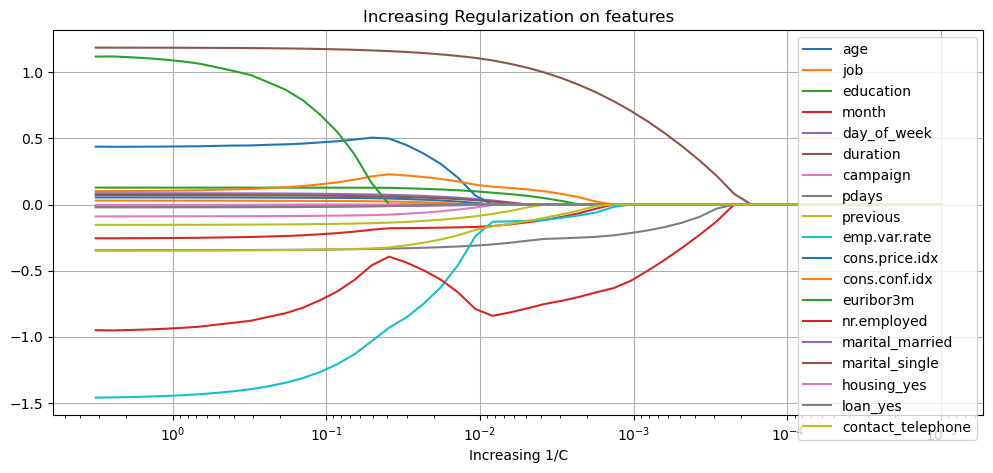

In [39]:
# Visualize the L1 selection
coef_list = []
Cs = np.logspace(-5, .5)
for C in Cs:
    lgr = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = C, random_state=42, max_iter = 1000).fit(X_scaled, y)
    coef_list.append(list(lgr.coef_[0]))
coef_df = pd.DataFrame(coef_list, columns = X_scaled.columns)
coef_df.index = Cs

plt.figure(figsize = (12, 5))
plt.semilogx(coef_df)
plt.gca().invert_xaxis()
plt.grid()
plt.legend(list(coef_df.columns));
plt.title('Increasing Regularization on features')
plt.xlabel("Increasing 1/C")

In [40]:
# Let's keep a smaller dataset
df_small = X_scaled[best_features]
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39791 entries, 0 to 39790
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   education          39791 non-null  float64
 1   month              39791 non-null  float64
 2   duration           39791 non-null  float64
 3   pdays              39791 non-null  float64
 4   previous           39791 non-null  float64
 5   emp.var.rate       39791 non-null  float64
 6   cons.price.idx     39791 non-null  float64
 7   cons.conf.idx      39791 non-null  float64
 8   euribor3m          39791 non-null  float64
 9   nr.employed        39791 non-null  float64
 10  marital_single     39791 non-null  float64
 11  contact_telephone  39791 non-null  float64
dtypes: float64(12)
memory usage: 3.6 MB


In [41]:
# Split train, test + stratification

X_train, X_test, y_train, y_test = train_test_split(df_small, y, test_size=0.25, random_state=42, stratify=y)

### <br><center>KNN MODEL</center>

#### Grid searching the best params for KNN

In [42]:
# Grid search best hyperparameters
params2 = {'n_neighbors' : [1,3,5,7,9,11,13,15,17,19,21],
          'p' : [1,2],
          'weights' : ['uniform','distance']}

start = time.time()
grid_knn = GridSearchCV(estimator = KNeighborsClassifier(), scoring = 'roc_auc', param_grid = params2)

# Fit on training set
grid_knn.fit(X_train,y_train)
knn_searchfit_time = time.time() - start

# Predict
start = time.time()
y_pred = grid_knn.best_estimator_.predict_proba(X_test)
knn_inference_time = time.time() - start

# Results
knn_best_k = grid_knn.best_params_
knn_train_acc = grid_knn.score(X_train,y_train) 
knn_test_acc = grid_knn.score(X_test,y_test)

print(f'Best parameters: {knn_best_k}')
print(f'Train accuracy: {round(knn_train_acc,6)}')
print(f'Test accuracy: {round(knn_test_acc,6)}')
print(f'Search+Fit time: {round(knn_searchfit_time,6)}s')
print(f'Inference time: {round(knn_inference_time,6)}s')

Best parameters: {'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}
Train accuracy: 0.947348
Test accuracy: 0.931879
Search+Fit time: 46.603298s
Inference time: 0.383552s


#### Compare scores (accuracy, precision, recall and roc auc) for different thresholds

In [43]:
# Get scores from various thresholds
Ts = np.round(np.linspace(.1, .9, 9),2)
Accs = []
Ps = []
Rs = []
ROCs = []
FPRs = []
TPRs = []

for t in Ts:
    a, p, r, roc, fpr, tpr = get_scores_by_threshold(y_test, y_pred, thresh = t)
    Accs.append(a)
    Ps.append(p)
    Rs.append(r)
    ROCs.append(roc)
    FPRs.append(fpr)
    TPRs.append(tpr)
#    print(f'scores {round(t*100,2)}%: {a} {p} {r} {roc}')
end = time.time()

df_dict = {
    'Threshold':Ts,
    'Accuracy':Accs,
    'Precision':Ps,
    'Recall':Rs,
    'ROC':ROCs
}

knn_df = pd.DataFrame(df_dict).set_index('Threshold')
knn_df

Accuracy  Precision    Recall       ROC
Threshold                                         
0.1        0.848512   0.421907  0.926916  0.882731
0.2        0.882187   0.487258  0.852050  0.869034
0.3        0.900281   0.542153  0.745098  0.832554
0.4        0.908022   0.590078  0.604278  0.775457
0.5        0.908926   0.628878  0.469697  0.717230
0.6        0.906112   0.684314  0.311052  0.646405
0.7        0.899779   0.743191  0.170232  0.581377
0.8        0.893546   0.773913  0.079323  0.538188
0.9        0.888822   0.722222  0.023173  0.511020

#### Visualize the scores and the ROC curves

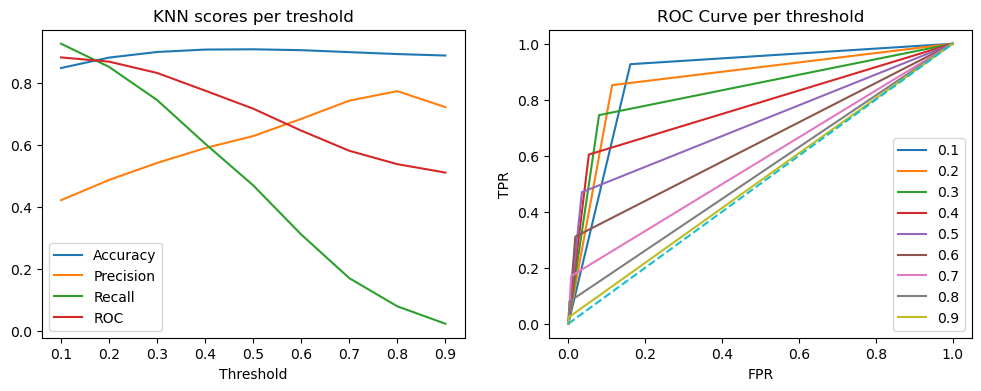

In [44]:
# Visualize how KNN performs on various metrics and thresholds

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes = axes.ravel() 

knn_df.plot(ax = axes[0])
axes[0].set_title("KNN scores per treshold")

for f,t in zip(FPRs,TPRs):
    axes[1].plot(f,t)
axes[1].plot([0,1],[0,1],'--') 
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].set_title("ROC Curve per threshold")
axes[1].legend(Ts)
plt.show()

#### Conclusion

> With a very low threshold at 10% of confidence, the model yields the best recall and ROC scores (92.7% and 88.3% respectively) which will help find most of the potential prospects. However, due to the poor precision and accuracy (84.8% and 42.2% respectively), we can expect to get a lot of false positives. Let's compare with other models.

### <br><center>LOGISTIC REGRESSION MODEL</center>

#### Grid searching the best params for LR

In [45]:
# Grid search best hyperparameters
params = {'class_weight' : [None, 'balanced'],
         'C' : [0.01,0.1,1,10,100],
         'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

start = time.time()
grid_lr = GridSearchCV(estimator = LogisticRegression(), scoring = 'roc_auc', param_grid = params)

# Fit on training set
grid_lr.fit(X_train,y_train)
lr_searchfit_time = time.time() - start

# Predict
start = time.time()
y_pred = grid_lr.best_estimator_.predict_proba(X_test)
lr_inference_time = time.time() - start

# Results
lr_best_k = grid_lr.best_params_
lr_train_acc = grid_lr.score(X_train,y_train)
lr_test_acc = grid_lr.score(X_test,y_test)

print(f'Best parameters: {lr_best_k}')
print(f'Train accuracy: {round(lr_train_acc,6)}')
print(f'Test accuracy: {round(lr_test_acc,6)}')
print(f'Search+Fit time: {round(lr_searchfit_time,6)}s')
print(f'Inference time: {round(lr_inference_time,6)}s')

Best parameters: {'C': 1, 'class_weight': 'balanced', 'solver': 'sag'}
Train accuracy: 0.930974
Test accuracy: 0.934401
Search+Fit time: 24.147961s
Inference time: 0.002001s


#### Compare scores (accuracy, precision, recall and roc auc) for different thresholds

In [46]:
# Get scores from various thresholds
Ts = np.round(np.linspace(.1, .9, 9),2)
Accs = []
Ps = []
Rs = []
ROCs = []
FPRs = []
TPRs = []

for t in Ts:
    a, p, r, roc, fpr, tpr = get_scores_by_threshold(y_test, y_pred, thresh = t)
    Accs.append(a)
    Ps.append(p)
    Rs.append(r)
    ROCs.append(roc)
    FPRs.append(fpr)
    TPRs.append(tpr)
#    print(f'scores {round(t*100,2)}%: {a} {p} {r} {roc}')
end = time.time()

df_dict = {
    'Threshold':Ts,
    'Accuracy':Accs,
    'Precision':Ps,
    'Recall':Rs,
    'ROC':ROCs
}

lr_df = pd.DataFrame(df_dict).set_index('Threshold')
lr_df

Accuracy  Precision    Recall       ROC
Threshold                                         
0.1        0.604142   0.220856  0.992870  0.773797
0.2        0.727382   0.290127  0.979501  0.837416
0.3        0.792622   0.348373  0.963458  0.867181
0.4        0.832831   0.396320  0.921569  0.871559
0.5        0.860173   0.440036  0.879679  0.868686
0.6        0.881383   0.484753  0.821747  0.855356
0.7        0.896361   0.528707  0.746881  0.831122
0.8        0.907720   0.584298  0.630125  0.786567
0.9        0.909027   0.635795  0.452763  0.709896

#### Visualize the scores and the ROC curves

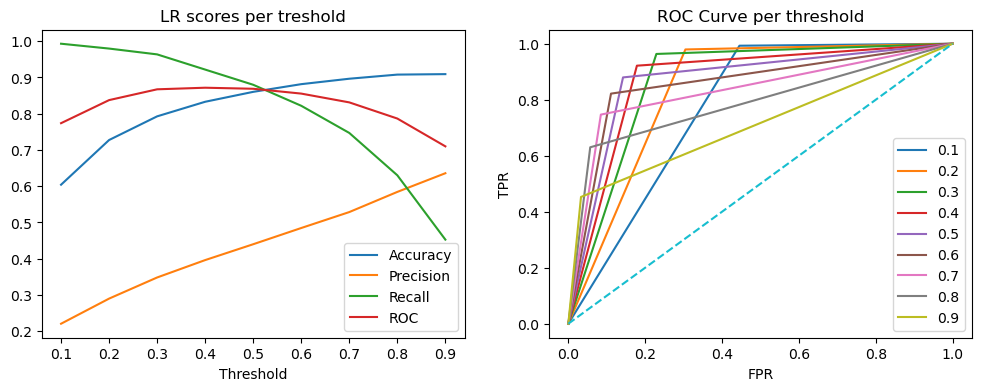

In [47]:
# Visualize how Logistic Regression performs on various metrics and thresholds

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes = axes.ravel() 

lr_df.plot(ax = axes[0])
axes[0].set_title("LR scores per treshold")

for f,t in zip(FPRs,TPRs):
    axes[1].plot(f,t)
axes[1].plot([0,1],[0,1],'--') 
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].set_title("ROC Curve per threshold")
axes[1].legend(Ts)
plt.show()

#### Conclusion

> With a lower threshold at 40% of confidence, the model yields the best compromise between the different metrics: ROC is the highest at 87.2% and recall is at 92.2% while accuracy and precision stand at 83.3% and 39.6% respectively. This is not beating our previous KNN model so we will not retain this model either. 

### <br><center>DECISION TREE MODEL</center>

#### Grid searching the best params for Decision Tree

In [48]:
# Grid search best hyperparameters
params = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
         'min_samples_split': [2,4,6,8,10,12,14,16,18,20],
          'criterion': ['gini','entropy','log_loss'],
          'min_samples_leaf': [1,2,5,10,15,20],
          'class_weight': [None,'balanced']
         }

start = time.time()
#grid_tree = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 42), scoring = 'accuracy', param_grid=params).fit(X_train,y_train)
grid_tree = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state = 42), scoring = 'roc_auc', param_distributions=params,n_iter=270)

# Fit on training set
grid_tree.fit(X_train,y_train)
tree_searchfit_time = time.time() - start

# Predict
start = time.time()
y_pred = grid_tree.best_estimator_.predict_proba(X_test)
tree_inference_time = time.time() - start

# Results
tree_best_k = grid_tree.best_params_
tree_train_acc = grid_tree.score(X_train,y_train)
tree_test_acc = grid_tree.score(X_test,y_test)

print(f'Best parameters: {tree_best_k}')
print(f'Train accuracy: {round(tree_train_acc,6)}')
print(f'Test accuracy: {round(tree_test_acc,6)}')
print(f'Search+Fit time: {round(tree_searchfit_time,6)}s')
print(f'Inference time: {round(tree_inference_time,6)}s')

Best parameters: {'min_samples_split': 16, 'min_samples_leaf': 20, 'max_depth': 7, 'criterion': 'log_loss', 'class_weight': 'balanced'}
Train accuracy: 0.948612
Test accuracy: 0.942857
Search+Fit time: 42.844065s
Inference time: 0.001001s


#### Compare scores (accuracy, precision, recall and roc auc) for different thresholds

In [49]:
# Get scores from various thresholds
Ts = np.round(np.linspace(.1, .9, 9),2)
Accs = []
Ps = []
Rs = []
ROCs = []
FPRs = []
TPRs = []

for t in Ts:
    a, p, r, roc, fpr, tpr = get_scores_by_threshold(y_test, y_pred, thresh = t)
    Accs.append(a)
    Ps.append(p)
    Rs.append(r)
    ROCs.append(roc)
    FPRs.append(fpr)
    TPRs.append(tpr)
#    print(f'scores {round(t*100,2)}%: {a} {p} {r} {roc}')
end = time.time()

df_dict = {
    'Threshold':Ts,
    'Accuracy':Accs,
    'Precision':Ps,
    'Recall':Rs,
    'ROC':ROCs
}

tree_df = pd.DataFrame(df_dict).set_index('Threshold')
tree_df

Accuracy  Precision    Recall       ROC
Threshold                                         
0.1        0.706172   0.276606  0.993761  0.831687
0.2        0.742059   0.302408  0.984848  0.848021
0.3        0.812525   0.371764  0.959893  0.876842
0.4        0.827402   0.390424  0.944742  0.878614
0.5        0.837354   0.403652  0.926025  0.876053
0.6        0.882891   0.488969  0.849376  0.868264
0.7        0.887716   0.501326  0.842246  0.867871
0.8        0.907218   0.569923  0.722816  0.826738
0.9        0.913550   0.658596  0.484848  0.726449

#### Visualize the scores and the ROC curves

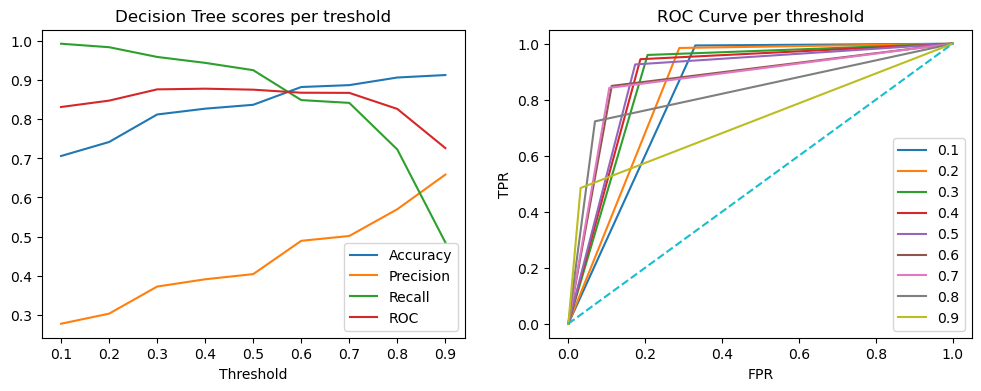

In [50]:
# Visualize how Decision Tree performs on various metrics and thresholds

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes = axes.ravel() 

tree_df.plot(ax = axes[0])
axes[0].set_title("Decision Tree scores per treshold")

for f,t in zip(FPRs,TPRs):
    axes[1].plot(f,t)
axes[1].plot([0,1],[0,1],'--') 
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].set_title("ROC Curve per threshold")
axes[1].legend(Ts)
plt.show()

#### Conclusion

> With a lower threshold at 40% of confidence, the model yields the best compromise between the different metrics: ROC is the highest at 87.9% and recall is at 94.5% while accuracy and precision stand at 82.7% and 39% respectively. For a close accuracy and precision compared to KNN, this model will perform better on recall.

### <br><center>SUPPORT VECTOR MACHINE MODEL</center>

#### Grid searching the best params for SVM

In [51]:
# Grid search best hyperparameters
params = {'kernel': ['rbf', 'linear', 'sigmoid'],
         'gamma': [0.1, 1.0, 10.0]}

start = time.time()
grid_svc = GridSearchCV(estimator = SVC(probability=True,class_weight='balanced'), scoring = 'roc_auc', param_grid = params)

# Fit on training set
grid_svc.fit(X_train,y_train)
svc_searchfit_time = time.time() - start

# Predict
start = time.time()
y_pred = grid_svc.best_estimator_.predict_proba(X_test)
svc_inference_time = time.time() - start

# Results
svc_best_k = grid_svc.best_params_
svc_train_acc = grid_svc.score(X_train,y_train)
svc_test_acc = grid_svc.score(X_test,y_test)

print(f'Best parameters: {svc_best_k}')
print(f'Train accuracy: {round(svc_train_acc,6)}')
print(f'Test accuracy: {round(svc_test_acc,6)}')
print(f'Search+Fit time: {round(svc_searchfit_time,6)}s')
print(f'Inference time: {round(svc_inference_time,6)}s')

Best parameters: {'gamma': 0.1, 'kernel': 'rbf'}
Train accuracy: 0.938855
Test accuracy: 0.93344
Search+Fit time: 3000.265925s
Inference time: 6.05029s


#### Compare scores (accuracy, precision, recall and roc auc) for different thresholds

In [52]:
# Get scores from various thresholds
Ts = np.round(np.linspace(.1, .9, 9),2)
Accs = []
Ps = []
Rs = []
ROCs = []
FPRs = []
TPRs = []

for t in Ts:
    a, p, r, roc, fpr, tpr = get_scores_by_threshold(y_test, y_pred, thresh = t)
    Accs.append(a)
    Ps.append(p)
    Rs.append(r)
    ROCs.append(roc)
    FPRs.append(fpr)
    TPRs.append(tpr)
#    print(f'scores {round(t*100,2)}%: {a} {p} {r} {roc}')
end = time.time()

df_dict = {
    'Threshold':Ts,
    'Accuracy':Accs,
    'Precision':Ps,
    'Recall':Rs,
    'ROC':ROCs
}

svc_df = pd.DataFrame(df_dict).set_index('Threshold')
svc_df

Accuracy  Precision    Recall       ROC
Threshold                                         
0.1        0.837455   0.405209  0.942959  0.883501
0.2        0.860374   0.441319  0.894831  0.875412
0.3        0.877664   0.476309  0.851159  0.866096
0.4        0.895155   0.524765  0.745989  0.830053
0.5        0.895657   0.577491  0.278966  0.626510
0.6        0.890933   0.609467  0.091800  0.542161
0.7        0.888621   0.645833  0.027629  0.512852
0.8        0.887917   0.705882  0.010695  0.505064
0.9        0.887214   0.500000  0.001783  0.500778

#### Visualize the scores and the ROC curves

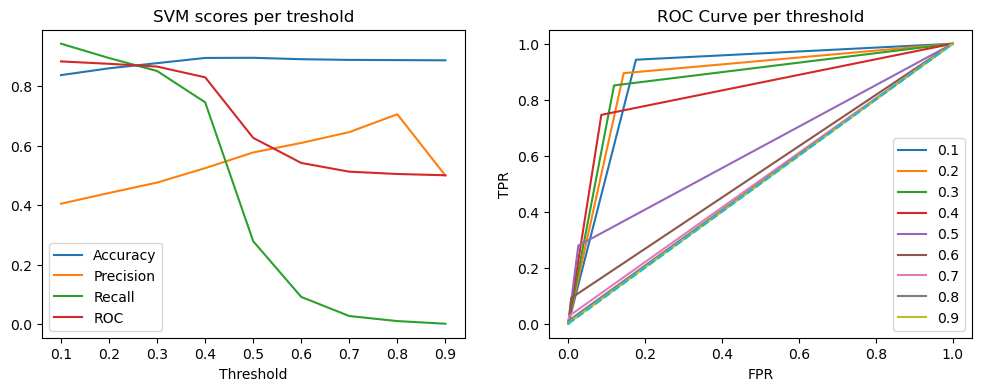

In [53]:
# Visualize how SVM performs on various metrics and thresholds

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes = axes.ravel() 

svc_df.plot(ax = axes[0])
axes[0].set_title("SVM scores per treshold")

for f,t in zip(FPRs,TPRs):
    axes[1].plot(f,t)
axes[1].plot([0,1],[0,1],'--') 
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].set_title("ROC Curve per threshold")
axes[1].legend(Ts)
plt.show()

#### Identify the most important features

Text(0.5, 0, 'Permutation Importance')

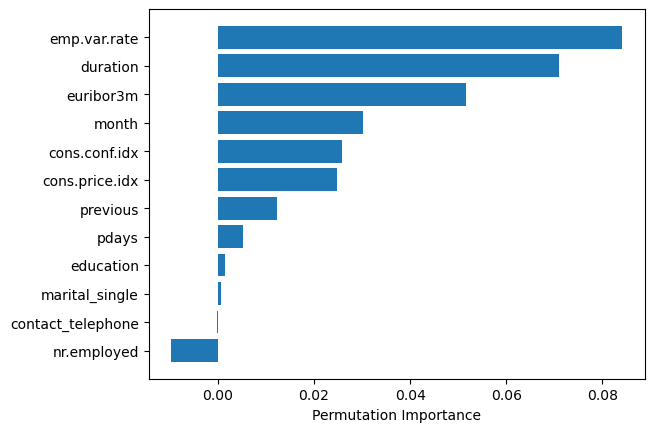

In [54]:
svc_best_model = grid_svc.best_estimator_
perm_importance = permutation_importance(svc_best_model, X_test, y_test)

feature_names = X_test.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

#### Conclusion

> By setting a threshold at 10% confidence that a prospect will convert, the model yields the best compromise between the different metrics: ROC is the highest at 88.35% and recall is at 94.3% while accuracy and precision stand at 83.7% and 40.5% respectively. 

### <br><center>MODELS COMPARISON AND CONCLUSION</center>

In [67]:
knn_df.loc[0.1,:]

Accuracy     0.848512
Precision    0.421907
Recall       0.926916
ROC          0.882731
Name: 0.1, dtype: float64

In [94]:
# Build the comparable
result = pd.DataFrame(lr_df.T[0.4]).rename(columns = {0.4:'LR 40%'})
result['KNN 10%'] = knn_df.T[0.1]
result['TREE 40%'] = tree_df.T[0.4]
result['SVM 10%'] = svc_df.T[0.1]

result.loc['Search & Fit Time'] = [lr_searchfit_time, knn_searchfit_time, tree_searchfit_time, svc_searchfit_time]
result.loc['Inference Time'] = [lr_inference_time, knn_inference_time, tree_inference_time, svc_inference_time]

result

0.871559


LR 40%    KNN 10%   TREE 40%      SVM 10%
Accuracy            0.832831   0.848512   0.827402     0.837455
Precision           0.396320   0.421907   0.390424     0.405209
Recall              0.921569   0.926916   0.944742     0.942959
ROC                 0.871559   0.882731   0.878614     0.883501
Search & Fit Time  24.147961  46.603298  42.844065  3000.265925
Inference Time      0.002001   0.383552   0.001001     6.050290

### CONCLUSION

> - KNN and SVM are the 2 models that perform better on the metrics that matter for this business case, ie. the ROC AUC and Recall metrics. The reason we focus on these metrics is that we are trying to find as many potential prospect that could convert to improve conversion and thus we accept having more false positives than false negatives. 
> - KNN manages to perform slightly better than SVM on the Accuracy and Precision metrics, while being faster on both training and inference times, which makes it my preferred choice as a more balanced and reasonable model.
> - However, the interpretability of the feature importance brought by SVM is also an interesting insight for the company. We were able to learn that features such as the duration of the call, the month of the call, whether a previous call occurred already and when, and some social and economic context attributes play a role in the conversion.
> - Moving forward: dealing with the imbalance of the dataset using SMOTE would certainly improve the performance of certain models. 